In [1]:
%cd ..

/home/oleg


In [7]:
# type: ignore

import typing
from typing import Any, cast

import gigaam
from gigaam.model import GigaAMASR
import jiwer
from datasets import Dataset, load_dataset, Audio
import numpy as np
import numpy.typing as npt
import pandas as pd

from asr_eval.streaming.sender import StreamingAudioSender
from asr_eval.streaming.caller import transсribe_parallel
from asr_eval.streaming.models.vosk import VoskStreaming
from asr_eval.streaming.model import TranscriptionChunk
from asr_eval.streaming.evaluation import get_word_timings, get_partial_alignments, remap_time
from asr_eval.streaming.plots import partial_alignment_diagram, visualize_history

In [ ]:
gigaam_model = typing.cast(GigaAMASR, gigaam.load_model('ctc', device='cuda'))

In [3]:
# type: ignore

dataset: Dataset = load_dataset('bond005/podlodka_speech')['test'].take(1)
dataset = dataset.cast_column("audio", Audio(sampling_rate=16_000))
df = pd.DataFrame(list(dataset))

def get_streaming_sender(id: str, audio: dict[str, Any]) -> dict[str, Any]:
    return StreamingAudioSender(
        id=id,
        audio=np.int16(audio['array'] * 32768).tobytes(),
        array_len_per_sec=16_000 * 2,  # x2 because of the conversion float -> bytes
        real_time_interval_sec=1 / 5,
        speed_multiplier=1,
        verbose=False,
    )

df['id'] = df.audio.apply(lambda audio: audio['path'])
df['sender'] = df.apply(lambda row: get_streaming_sender(row.id, row.audio), axis=1)

In [4]:
# type: ignore

asr = VoskStreaming(model_name='vosk-model-ru-0.42', chunk_length_sec=1)
asr.start_thread()
results = transсribe_parallel(asr=asr, senders=df.sender, n_threads=1, send_all_without_delays=True)
asr.stop_thread()

LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=13 max-active=7000 lattice-beam=6
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 1 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 2 orphan components.
LOG (VoskAPI:Collapse():nnet-utils.cc:1488) Added 1 components, removed 2
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from /home/oleg/.cache/vosk/vosk-model-ru-0.42/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:279) Loading HCLG from /home/oleg/.cache/vosk/vosk-model-ru-0.42/graph/HCLG.fst
LOG (VoskAPI:ReadDataFiles():model.cc:297) Loading words from /home/oleg/.cache/vosk/vosk-model-ru-0.42/graph/words.txt
LOG (VoskAPI:ReadDataFiles():model.cc:30

Transcribing sound_test_0001.wav
Transcribed sound_test_0001.wav: и поэтому использовать их в повседневности не получается мы вынуждены отступать


In [6]:
# type: ignore

df['preds'] = [TranscriptionChunk.join(x) for x in results.values()]

jiwer.wer(reference=df['transcription'].tolist(), hypothesis=df['preds'].tolist())

0.46153846153846156

In [6]:
# TODO защита против нескольких транскрипций

[InputChunk(data=b'', start_time=0, end_time=0.2, put_timestamp=1750079407.424682, get_timestamp=1750079407.4250844),
 InputChunk(data=b'', start_time=0.2, end_time=0.4, put_timestamp=1750079407.4247158, get_timestamp=1750079407.4250946),
 InputChunk(data=b'', start_time=0.4, end_time=0.6000000000000001, put_timestamp=1750079407.424729, get_timestamp=1750079407.4251027),
 InputChunk(data=b'', start_time=0.6000000000000001, end_time=0.8, put_timestamp=1750079407.424743, get_timestamp=1750079407.4251347),
 InputChunk(data=b'', start_time=0.8, end_time=1.0, put_timestamp=1750079407.4247506, get_timestamp=1750079407.425148)]

[OutputChunk(data=TranscriptionChunk(uid='26b4a3bd-977e-4b8a-94a1-a6d5bc7c9bc1', text=''), seconds_processed=1.0, put_timestamp=1750079407.4935434, get_timestamp=1750079407.493685),
 OutputChunk(data=TranscriptionChunk(uid='26b4a3bd-977e-4b8a-94a1-a6d5bc7c9bc1', text=''), seconds_processed=2.0, put_timestamp=1750079407.8029711, get_timestamp=1750079407.8030882),
 OutputChunk(data=TranscriptionChunk(uid='26b4a3bd-977e-4b8a-94a1-a6d5bc7c9bc1', text='и поэтому'), seconds_processed=3.0, put_timestamp=1750079408.247131, get_timestamp=1750079408.2472699),
 OutputChunk(data=TranscriptionChunk(uid='26b4a3bd-977e-4b8a-94a1-a6d5bc7c9bc1', text='и поэтому использовать их в повседневности не'), seconds_processed=4.0, put_timestamp=1750079408.6650386, get_timestamp=1750079408.6682768),
 OutputChunk(data=TranscriptionChunk(uid='26b4a3bd-977e-4b8a-94a1-a6d5bc7c9bc1', text='и поэтому использовать их в повседневности не получается'), seconds_processed=5.0, put_timestamp=1750079408.9670699, get_timestam

[PartialAlignment(alignment=MatchesList(matches=[(и, ), (поэтому, )], total_true_len=2, score=AlignmentScore(n_word_errors=2, n_correct=0, n_char_errors=8)), audio_seconds_sent=1.0, audio_seconds_processed=1.0, real_seconds_overhead=0),
 PartialAlignment(alignment=MatchesList(matches=[(и, ), (поэтому, ), (использовать, ), (их, ), (в, )], total_true_len=5, score=AlignmentScore(n_word_errors=5, n_correct=0, n_char_errors=23)), audio_seconds_sent=2.2, audio_seconds_processed=2.0, real_seconds_overhead=0),
 PartialAlignment(alignment=MatchesList(matches=[(и, и), (поэтому, поэтому), (использовать, ), (их, ), (в, ), (повседневности, ), (не, )], total_true_len=7, score=AlignmentScore(n_word_errors=5, n_correct=2, n_char_errors=31)), audio_seconds_sent=3.4000000000000004, audio_seconds_processed=3.0, real_seconds_overhead=0),
 PartialAlignment(alignment=MatchesList(matches=[(и, и), (поэтому, поэтому), (использовать, использовать), (их, их), (в, в), (повседневности, повседневности), (не, не), (

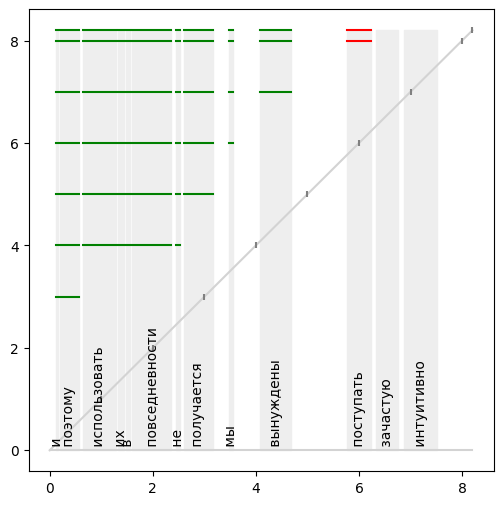

In [8]:
sample = df.iloc[0] # type: ignore
waveform = cast(npt.NDArray[np.floating], sample['audio']['array'])
text = cast(str, sample['transcription'])
sender = cast(StreamingAudioSender, sample.sender) # type: ignore
input_chunks = sender.history
output_chunks = results[sample['id']]
cutoffs = sender.get_send_times()

word_timings = get_word_timings(gigaam_model, waveform, text)

input_chunks_remapped, output_chunks_remapped = remap_time(cutoffs, input_chunks, output_chunks)

partial_alignments = get_partial_alignments(input_chunks_remapped, output_chunks_remapped, word_timings, processes=1) # type: ignore

# visualize_history(input_chunks, output_chunks)
# visualize_history(input_chunks_remapped, output_chunks_remapped)

display(input_chunks[:5])
display(output_chunks[:5])
display(partial_alignments[:5])

assert input_chunks[-1].end_time is not None

partial_alignment_diagram(
    partial_alignments,
    word_timings,
    audio_len=input_chunks[-1].end_time,  # TODO: may be not precise
    figsize=(6, 6),
    y_type='processed',
)

In [17]:
# print('Final transcription:', TranscriptionChunk.join(output_chunks))

# true_token_id_to_time_span = {
#     token.id: (start, end) for token, start, end in word_timings
# }

# last_word_end = [
#     max([
#         true_token_id_to_time_span[m.true[-1].id][-1]
#         for m in partial_al.alignment.matches
#         if m.status not in ('deletion', 'insertion')
#     ] or [0])
#     for partial_al in partial_alignments
# ]

# latency_sent = [p.audio_seconds_sent - end for p, end in zip(partial_alignments, last_word_end)]
# print(f'Average latency (sent): {np.mean(latency_sent):.1f} sec')

# latency_processed = [p.audio_seconds_processed - end for p, end in zip(partial_alignments, last_word_end)] # type: ignore
# print(f'Average latency (processed): {np.mean(latency_processed):.1f} sec') # type: ignore